This notebook is taught to be the main script, containing also information that were shown on the poster. A principal component analysis (PCA) was combined with a support vector classifier (SVC). Hyperparameter search and optimization was done via GridSearchCV. A nested crossvalidation is wrapped around to evaluate models generalization capabilities.

In [1]:
#data sources:
txpath = 'toxicity_labels.csv'
data = 'data.csv'
un = 'unknown_data.csv'

In [2]:
#General imports
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
#method specific imports
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import make_scorer

In [3]:
#parsing

#labels
y_id = []
y = []
file = open(txpath, "r")
for line in file:
    ys = line.strip().split(",")
    y_id.append(ys[0])
    y.append(ys[1].replace('NA', '2'))
file.close()
#data
X_id = []
X = []
file = open(data, "r")
for line in file:
    ys = line.strip().split(",")
    X_id.append(ys[0])
    X.append(ys[1:])
file.close() 
#unknown data
Xu_id = []
Xu = []
file = open(un, "r")
for line in file:
    ys = line.strip().split(",")
    Xu_id.append(ys[0])
    Xu.append(ys[1:])    
file.close()

In [4]:
#conversion of lists to numpy arrays and re-definition of data types
y_id = np.array(y_id[1:])
X_id = np.array(X_id[1:])
Xu_id = np.array(Xu_id[1:])
y_head = np.array(y[0])
X_head = np.array(X[0])

#re-definition of data types
X = np.array(X[1:], dtype='float64')
Xu = np.array(Xu[1:], dtype='float64')
y = np.array(y[1:], dtype='i1')  # int8

In [5]:
#preprocessing

#cleaning of data with missing labels
#(Number of values with missing label NA: 3619)
rm = np.where(y == 2)
X = np.delete(X, rm[0], axis=0)
X_id = np.delete(X_id, rm[0])
y = np.delete(y, rm[0])
y_id = np.delete(y_id, rm[0])

#normalization (zero-score method)
scaler = StandardScaler()
X = scaler.fit_transform(X)
Xu = scaler.transform(Xu)

r for explanation of 0.90 is 62 features
PC 1 is accounting for 31.73 percent of the data
PC 2 is accounting for 6.66 percent of the data


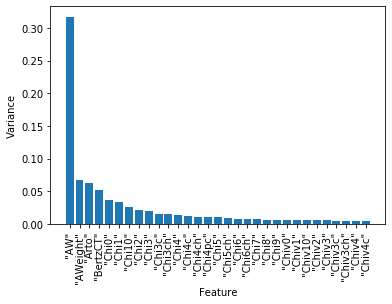

In [6]:
#data overview - visualization of data variance and PCA

#conducting the PCA
C = np.cov(X.T)
d, V = np.linalg.eig(C)
ind = np.argsort(d)[::-1]
#complex data handling -> extracting the real part
if d.dtype == complex:
    d = d.real
if V.dtype == complex:
    V = V.real
d = d[ind]
V = V[:,ind]
X_head[ind]

#define lower dimensional representation to be 90%
required_explanation=0.90
for i in range(2,C.shape[1]):
    ratios_variance_explained = d/d.sum()
    va = ratios_variance_explained[0:i].sum()
    if va>required_explanation:
        print("r for explanation of %.2f is %d features" %(required_explanation,i))
        break
print('PC 1 is accounting for %.2f percent of the data' % (ratios_variance_explained[0]*100))
print('PC 2 is accounting for %.2f percent of the data' % (ratios_variance_explained[1]*100))        
#Xr = lower dimensional representation of the data
#Xt = reconstructed original data
Xr = np.dot(X, V[:, 0:i])
Xt = np.dot(X, V)

#visualization of variance distribution among features
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(X_head[0:i//2], ratios_variance_explained[0:i//2])
ax.set_xticks(np.arange(0, len(X_head[0:i//2])))
ax.set_xticklabels(X_head[0:i//2], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.savefig('variance.pdf')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


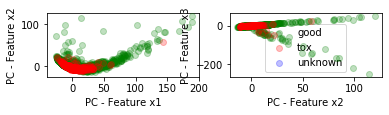

In [7]:
#visualization of toxic and pnon toxic data between different principal components
#number of components to visualize can be adapted with number_of_PCs =
number_of_PCs = 3

#separation of toxic, non toxic and unknown data
ind = np.where(y == 1)[0]
indu = np.where(y == 2)[0]
tox = Xt[ind]
unkn = Xt[indu]
good = np.delete(Xt, np.append(ind, indu), axis=0)
#acutal visualization
fig = plt.figure()
for i in range(1, number_of_PCs):
    ax = fig.add_subplot(number_of_PCs, 2, i)
    ax.scatter(good[:, i - 1], good[:, i], alpha=0.25, label='good', zorder=30, color='green')
    ax.scatter(tox[:, i - 1], tox[:, i], alpha=0.25, label='tox', zorder=30, color='red')
    ax.scatter(unkn[:, i - 1], unkn[:, i], alpha=0.25, label='unknown', zorder=30, color='blue')
    ax.set_xlabel("PC - Feature x" + str(i))
    ax.set_ylabel("PC - Feature x" + str(i + 1))
plt.legend(loc='lower center')
fig.tight_layout(h_pad=50)
plt.savefig('pca.pdf')
plt.show()

Model: PCA with a SVC
Optimized Parameter: pca:number of PCs;; svm: kernels, gamma, C

steps:
define pipeline for kpca and logistic regression
wrap cross validation (CV) around to create a nested CV
define parameters that should be optimized (pca components, gamma, kernels, C)
define scoring function (MCC)
apply parameter with a CV of 5 (GridSearchCV)
calculate different metrices of prediction and testing data to evaluate models
print results summary

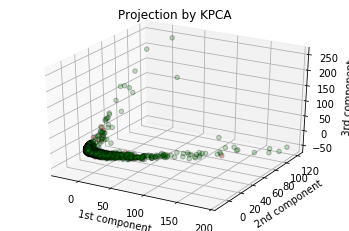

In [8]:
#KPCA

kpca = KernelPCA(n_components=80, kernel='linear',fit_inverse_transform=True, alpha=1)
Xr=kpca.fit_transform(X)
Xur=kpca.transform(Xu)

#Plot results
good = y == 0
toxic = y == 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xr[good, 0], Xr[good, 1], Xr[good, 2], c="green",
            s=20, edgecolor='k', alpha=0.25)
ax.scatter(Xr[toxic, 0], Xr[toxic, 1], Xr[toxic, 2], c="red",
            s=20, edgecolor='k', alpha=0.25)
ax.set_xlabel("1st component")
ax.set_ylabel("2nd component")
ax.set_zlabel("3rd component")
plt.title("Projection by KPCA")
plt.savefig('kpca.pdf')
plt.show()

In [9]:
#Main model

#lists to store metrices
auc_values_svm_rbf = []
precision_values = []
recall_values = []
accuracy_values = []
mcc_values = []
auc_values = []
best_C=[]
best_y=[]

#parameter definition that should be tested
params = {"C": np.logspace(-4,2,10),
          "gamma": np.logspace(-4,0,10)} 

#nested cross validation
cv = StratifiedKFold(n_splits=5,shuffle=True)
for train_index, val_index in cv.split(Xr,y):

    X_train = Xr[train_index]
    X_val = Xr[val_index]
    y_train = y[train_index]
    y_val = y[val_index]

    #scoring and hyperparameter definition/search
    svc = SVC(kernel="rbf")
    gridsearch = GridSearchCV(svc, params, cv=5, scoring=['f1','accuracy'], refit='f1',n_jobs=-1)
    gridsearch.fit(X_train,y_train)

    #calculation of different scores
    y_pred = gridsearch.predict(X_val)
    accuracy_values.append(metrics.accuracy_score(y_val, y_pred))
    recall_values.append(metrics.recall_score(y_val, y_pred))
    precision_values.append(metrics.precision_score(y_val, y_pred))
    mcc_values.append(metrics.matthews_corrcoef(y_val, y_pred))
    auc_values.append(metrics.roc_auc_score(y_val, y_pred))
    best_y.append(gridsearch.best_params_['gamma'])
    best_C.append(gridsearch.best_params_['C'])

#print scorings
print("Accuracy:\t%.2f (+-%.2f)" % (np.mean(accuracy_values),np.std(accuracy_values)))
print("Recall:\t\t%.2f (+-%.2f)" % (np.mean(recall_values),np.std(recall_values)))
print("Precision:\t%.2f (+-%.2f)" % (np.mean(precision_values),np.std(precision_values)))
print("MCC:\t\t%.2f (+-%.2f)" % (np.mean(mcc_values),np.std(mcc_values)))
print("AUC:\t%.2f (+-%.2f)" % (np.mean(auc_values), np.std(auc_values)))
print('hyperparameter selection:')
print('C: ' + str(best_C))
print('Gamma: ' + str(best_y))

Accuracy:	0.92 (+-0.00)
Recall:		0.56 (+-0.05)
Precision:	0.71 (+-0.03)
MCC:		0.59 (+-0.03)
AUC:	0.77 (+-0.02)
hyperparameter selection:
C: [21.54434690031882, 21.54434690031882, 100.0, 4.641588833612772, 21.54434690031882]
Gamma: [0.005994842503189409, 0.005994842503189409, 0.005994842503189409, 0.005994842503189409, 0.005994842503189409]


In [10]:
#export format for upload to the server
un_pred = gridsearch.predict(Xur)
un_pred = np.array(un_pred)
exp = np.column_stack((Xu_id, un_pred))
np.savetxt('exp_pca_svc.csv',exp, delimiter=',', fmt="%s")

print('Number of toxic labels of unknown data set %d' % np.sum(un_pred == 1))
print('Number of non-toxic labels of unknown data set %d' %np.sum(un_pred == 0))

Number of toxic labels of unknown data set 65
Number of non-toxic labels of unknown data set 545
